以“希拉里邮件”的主题问题为例，介绍gensim中的LDA模型

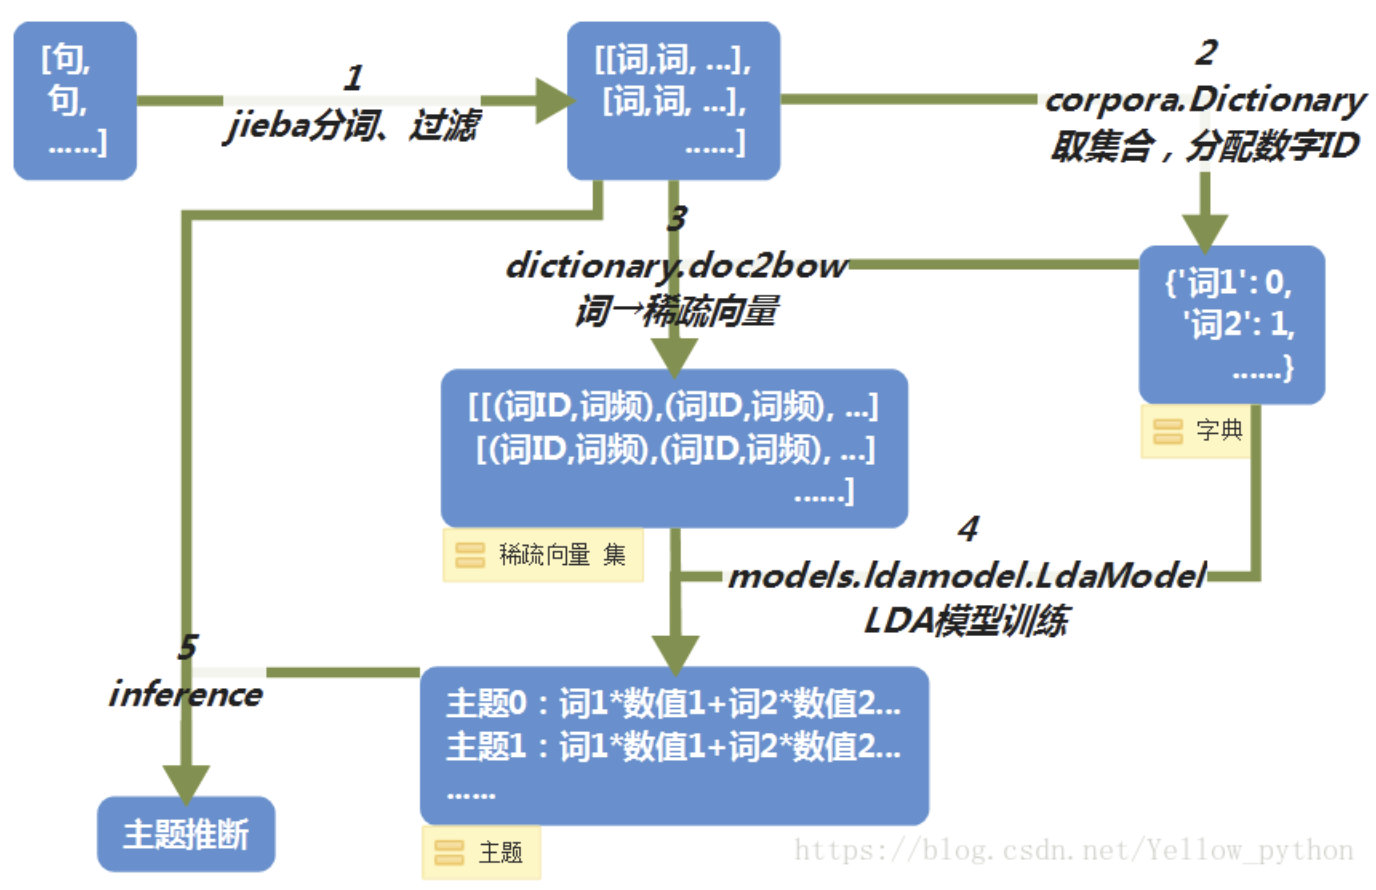

In [3]:
import pandas as pd
import numpy as np
import re

#### 载入数据

In [4]:
df = pd.read_csv('./data/HillaryEmails.csv')
df.head(3)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...


In [5]:
# 之取其中的ExtractedBodyText非空数据
df = df[['Id','ExtractedBodyText']].dropna()
df.head(3)

,Id,ExtractedBodyText
1,2,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,3,Thx
4,5,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


In [6]:
df.iloc[0, 1]

'B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary'

#### 文本预处理

In [7]:
# 采用正则表达式对文本进行清洗
def text_cleaner(text):
    text = text.replace("\n", " ")   # 行合并
    text = re.sub(r"-", " ", text)   # 去处-号
    text = re.sub(r"\d+/\d+/\d+", "", text)   # 去处日期，对主体模型没什么意义
    text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text)  #时间，没意义
    text = re.sub(r"[\w]+@[\.\w]+", "", text) #邮件地址，没意义
    text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text) #网址，没意义
    pure_text = ''
    # 挨个清洗，防止特殊字符
    for letter in text:
        if letter.isalpha() or letter==' ':
            pure_text += letter
    text = ' '.join(word for word in pure_text.split() if len(word)>1)
    return text

In [8]:
docs = df['ExtractedBodyText']
docs = docs.apply(lambda x: text_cleaner(x))

In [9]:
docs.head()

1    Thursday March PM Latest How Syria is aiding Q...
2                                                  Thx
4    Friday March PM Huma Abedin Fw Latest How Syri...
5    Pis print Wednesday September PM Fw Meet The R...
7    Friday March PM Huma Abedin Fw Latest How Syri...
Name: ExtractedBodyText, dtype: object

In [10]:
doclist = docs.values
doclist = doclist[:100]  # 取前100
doclist[99]

'Is Dan coming at'

#### 构建LDA模型

In [11]:
import gensim
from gensim import corpora, models, similarities

手动加载停用词

In [12]:
stoplist = ['very', 'ourselves', 'am', 'doesn', 'through', 'me', 'against', 'up', 'just', 'her', 'ours', 
            'couldn', 'because', 'is', 'isn', 'it', 'only', 'in', 'such', 'too', 'mustn', 'under', 'their', 
            'if', 'to', 'my', 'himself', 'after', 'why', 'while', 'can', 'each', 'itself', 'his', 'all', 'once', 
            'herself', 'more', 'our', 'they', 'hasn', 'on', 'ma', 'them', 'its', 'where', 'did', 'll', 'you', 
            'didn', 'nor', 'as', 'now', 'before', 'those', 'yours', 'from', 'who', 'was', 'm', 'been', 'will', 
            'into', 'same', 'how', 'some', 'of', 'out', 'with', 's', 'being', 't', 'mightn', 'she', 'again', 'be', 
            'by', 'shan', 'have', 'yourselves', 'needn', 'and', 'are', 'o', 'these', 'further', 'most', 'yourself', 
            'having', 'aren', 'here', 'he', 'were', 'but', 'this', 'myself', 'own', 'we', 'so', 'i', 'does', 'both', 
            'when', 'between', 'd', 'had', 'the', 'y', 'has', 'down', 'off', 'than', 'haven', 'whom', 'wouldn', 
            'should', 've', 'over', 'themselves', 'few', 'then', 'hadn', 'what', 'until', 'won', 'no', 'about', 
            'any', 'that', 'for', 'shouldn', 'don', 'do', 'there', 'doing', 'an', 'or', 'ain', 'hers', 'wasn', 
            'weren', 'above', 'a', 'at', 'your', 'theirs', 'below', 'other', 'not', 're', 'him', 'during', 'which']

In [13]:
texts = [[word for word in doc.lower().split() if word not in stoplist] for doc in doclist]

In [14]:
texts[0]

['thursday',
 'march',
 'pm',
 'latest',
 'syria',
 'aiding',
 'qaddafi',
 'sid',
 'hrc',
 'memo',
 'syria',
 'aiding',
 'libya',
 'docx',
 'hrc',
 'memo',
 'syria',
 'aiding',
 'libya',
 'docx',
 'march',
 'hillary']

In [15]:
# 建立语料库
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts ]
corpus[13]

[(51, 1), (505, 1), (506, 1), (507, 1), (508, 1)]

In [22]:
# 字典映射
dictionary.token2id

{'aiding': 0,
 'docx': 1,
 'hillary': 2,
 'hrc': 3,
 'latest': 4,
 'libya': 5,
 'march': 6,
 'memo': 7,
 'pm': 8,
 'qaddafi': 9,
 'sid': 10,
 'syria': 11,
 'thursday': 12,
 'thx': 13,
 'abedin': 14,
 'friday': 15,
 'fw': 16,
 'huma': 17,
 'pis': 18,
 'print': 19,
 'agreement': 20,
 'anti': 21,
 'behind': 22,
 'benghazi': 23,
 'case': 24,
 'cb': 25,
 'comm': 26,
 'date': 27,
 'deadly': 28,
 'department': 29,
 'dept': 30,
 'doc': 31,
 'droid': 32,
 'extremist': 33,
 'film': 34,
 'foia': 35,
 'fvluslim': 36,
 'house': 37,
 'httemaxbiumenthalcommeet': 38,
 'information': 39,
 'lte': 40,
 'meat': 41,
 'meet': 42,
 'musiim': 43,
 'muslim': 44,
 'produced': 45,
 'redactions': 46,
 'right': 47,
 'riots': 48,
 'select': 49,
 'sensitive': 50,
 'sent': 51,
 'september': 52,
 'sparked': 53,
 'state': 54,
 'subject': 55,
 'tihn': 56,
 'us': 57,
 'verizon': 58,
 'waiver': 59,
 'wednesday': 60,
 'wing': 61,
 'wireless': 62,
 'fyi': 63,
 'direct': 64,
 'druid': 65,
 'fwd': 66,
 'sending': 67,
 'sept':

In [16]:
# 建立lda模型
lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20)

In [17]:
# 查看某个主题的word分布
lda.print_topic(2, topn=3)

'0.021*"state" + 0.012*"us" + 0.010*"select"'

In [21]:
# 查看所有主题排名前五的词
for topic in lda.print_topics(num_words=5):
    print(topic)

(0, '0.021*"state" + 0.010*"like" + 0.009*"produced" + 0.008*"waiver" + 0.008*"sensitive"')
(1, '0.014*"state" + 0.012*"department" + 0.012*"pm" + 0.011*"office" + 0.010*"force"')
(2, '0.021*"state" + 0.012*"us" + 0.010*"select" + 0.009*"subject" + 0.009*"doc"')
(3, '0.024*"state" + 0.014*"us" + 0.013*"date" + 0.013*"doc" + 0.012*"sensitive"')
(4, '0.030*"state" + 0.018*"us" + 0.017*"benghazi" + 0.016*"house" + 0.016*"sensitive"')
(5, '0.012*"state" + 0.008*"subject" + 0.007*"department" + 0.007*"comm" + 0.007*"us"')
(6, '0.021*"state" + 0.011*"information" + 0.011*"benghazi" + 0.010*"us" + 0.010*"waiver"')
(7, '0.019*"september" + 0.015*"pm" + 0.013*"libya" + 0.012*"memo" + 0.011*"docx"')
(8, '0.011*"speak" + 0.008*"king" + 0.008*"keep" + 0.008*"holder" + 0.008*"secure"')
(9, '0.018*"state" + 0.011*"benghazi" + 0.010*"house" + 0.009*"department" + 0.008*"information"')
(10, '0.007*"president" + 0.007*"state" + 0.006*"obama" + 0.006*"libya" + 0.005*"said"')
(11, '0.021*"fyi" + 0.009*"s

In [18]:
# 文档-主题分布
lda.get_document_topics(corpus)

In [24]:
# 主题-word分布
lda.get_topic_terms(1)

[(54, 0.014433466),
 (29, 0.012304405),
 (8, 0.012164151),
 (1141, 0.011062112),
 (214, 0.0104525685),
 (5, 0.010092175),
 (80, 0.008486114),
 (380, 0.008114838),
 (1108, 0.006825991),
 (37, 0.0067875874)]

In [19]:
# 单词-主题分布
lda.get_term_topics(20)

[(4, 0.011377309), (14, 0.01704668)]

#### 主题推断

In [26]:
# 原语料的主题推断
for e, values in enumerate(lda.inference(corpus[0:5])[0]):
    print(texts[e])
    for ee, value in enumerate(values):
        print("主题{}推断值为{}".format(ee, value))

['thursday', 'march', 'pm', 'latest', 'syria', 'aiding', 'qaddafi', 'sid', 'hrc', 'memo', 'syria', 'aiding', 'libya', 'docx', 'hrc', 'memo', 'syria', 'aiding', 'libya', 'docx', 'march', 'hillary']
主题0推断值为0.05000000074505806
主题1推断值为0.05000000074505806
主题2推断值为0.05000000074505806
主题3推断值为0.05000000074505806
主题4推断值为0.05000000074505806
主题5推断值为0.05000000074505806
主题6推断值为0.05000000074505806
主题7推断值为0.05000000074505806
主题8推断值为0.05000000074505806
主题9推断值为0.05000000074505806
主题10推断值为0.05000000074505806
主题11推断值为0.05000000074505806
主题12推断值为0.05000000074505806
主题13推断值为0.05000000074505806
主题14推断值为22.049043655395508
主题15推断值为0.05000000074505806
主题16推断值为0.05000000074505806
主题17推断值为0.05000000074505806
主题18推断值为0.05000000074505806
主题19推断值为0.05000000074505806
['thx']
主题0推断值为0.05000000074505806
主题1推断值为0.05000000074505806
主题2推断值为0.05000000074505806
主题3推断值为0.05000000074505806
主题4推断值为0.05000000074505806
主题5推断值为0.05000000074505806
主题6推断值为0.05000000074505806
主题7推断值为0.05000000074505806
主题8推断值为0.05000000074505806
主题9

In [29]:
# 新文本的主题推断
new_text = "we will make China great again"
bow = dictionary.doc2bow([word for word in new_text.split() if word not in stoplist])
bow

[(283, 1), (677, 1)]

In [33]:
result = lda.inference([bow])[0]  # 注意要用[]包裹bow
for e, value in enumerate(result[0]):
    print("主题{}的推断值为{}".format(e, value))

主题0的推断值为0.05000000074505806
主题1的推断值为0.05000000074505806
主题2的推断值为0.05000000074505806
主题3的推断值为0.05000000074505806
主题4的推断值为0.05000000074505806
主题5的推断值为0.05000000074505806
主题6的推断值为0.05000000074505806
主题7的推断值为0.05000000074505806
主题8的推断值为0.05000000074505806
主题9的推断值为0.05000000074505806
主题10的推断值为0.05000000074505806
主题11的推断值为0.05000000074505806
主题12的推断值为0.05000000074505806
主题13的推断值为2.0496091842651367
主题14的推断值为0.05000000074505806
主题15的推断值为0.05000000074505806
主题16的推断值为0.05000000074505806
主题17的推断值为0.05000000074505806
主题18的推断值为0.05000000447034836
主题19的推断值为0.05000000074505806


In [55]:
# 单个词的主题
word_id = dictionary.doc2idx(['state'])
for i in lda.get_term_topics(word_id):
    print("China和主题{}的关系之为{}%".format(i[0],i[1][0]*100))

China和主题0的关系之为1.9823815673589706%
China和主题1的关系之为1.2505746446549892%
China和主题2的关系之为2.05790251493454%
China和主题3的关系之为2.355249598622322%
China和主题4的关系之为2.956966310739517%
China和主题5的关系之为1.0174131952226162%
China和主题6的关系之为1.9874930381774902%
China和主题9的关系之为1.7161965370178223%
China和主题12的关系之为1.9759923219680786%
China和主题14的关系之为5.1615871489048%
China和主题16的关系之为2.328598313033581%
China和主题19的关系之为1.3961643911898136%


#### 提高LDA模型结果的一些方法

方法一：根据词频调整稀疏矩阵，选择高频词<br>
方法二：根据词性标注调整系数矩阵，对于助动词、冠词、数量词等词性予以删除